# Predicting the continuous, perturbed development of the zebrafish

Similary to {doc}`200_zebrafish_continuous`, we make use of the [ZSCAPE](https://www.nature.com/articles/s41586-023-06720-2) dataset, which captures up to 23 perturbations at 5 different time points. Here, we leverage {class}`~cellflow.model.CellFlow` to interpolate the perturbed development at densely sampled time points.

## Preliminaries

In [1]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", SettingWithCopyWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import jax
import functools
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import rapids_singlecell as rsc
import flax.linen as nn
import optax
import cellflow
from cellflow.model import CellFlow
import cellflow.preprocessing as cfpp
from cellflow.utils import match_linear
from cellflow.plotting import plot_condition_embedding
from cellflow.preprocessing import transfer_labels, compute_wknn, centered_pca, project_pca, reconstruct_pca
from cellflow.metrics import compute_r_squared, compute_e_distance


/shared/edo/Projects/CellFlow_fork/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:2025-12-10 00:58:05,252:jax._src.xla_bridge:812: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-12-10 00:58:05 | [INFO] Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
W1210 00:58:05.474261 1732705 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [2]:
adata = cellflow.datasets.zesta()

We focus on the Central Nervous System, thus subset the data accordingly. We recompute a UMAP.

In [3]:
adata = adata[adata.obs["tissue"] == "Central Nervous System"]

We check the most relevant columns:
- {attr}`obs['timepoint'] <anndata.AnnData.obs>` the age of the embryo in hours post fertilization, as this covers a range from 18 to 72, we have created a columns `"logtime"` which stores the natural logarithm of `"timepoint"`. 
- {attr}`obs['gene1+gene2'] <anndata.AnnData.obs>` contains the genetic perturbation, which can be a single or a double genetic knockout. CellFlow requires as many {attr}`obs <anndata.AnnData.obs>` columns as the largest combination, which is 2 in our case. Hence, we created {attr}`obs['gene_target_1'] <anndata.AnnData.obs>` and {attr}`obs['gene_target_2'] <anndata.AnnData.obs>` which contain the single elements of the perturbation. Control cells have entries `"control"` in both columns, while single perturbations have `"control"` in {attr}`obs['gene_target_2'] <anndata.AnnData.obs>`.
- While not necessary for training CellFlow, it is handy to have {attr}`obs['condition'] <anndata.AnnData.obs>`, which contains the combination of the genetic perturbation and the time point.
- As we want to interpolate time points, we don't limit CellFlow to learn mappings from control to perturbed within the same time point as done in {doc}`200_zebrafish`, but we map from the first time point to all other time points. Hence, we use {attr}`obs['first_t_control'] <anndata.AnnData.obs>` for indicating the source population.

In [4]:
adata.obs.head()

,cell,Size_Factor,n.umi,perc_mitochondrial_umis,timepoint,Oligo,hash_umis,top_to_second_best_ratio,cell_type_sub,cell_type_broad,...,hash_plate,log.hash_umis,gene1+gene2,gene_target_1,gene_target_2,condition,is_control,first_t_control,logtime,germ_layer_adapted
A03_B01_P01-A02_LIG257,A03_B01_P01-A02_LIG257,0.468889,213.0,0.938967,18.0,18h_ctrl-noto_P3_D7,24.0,21.347128,neural progenitor (hindbrain R7/8),neural progenitor (hindbrain R7/8),...,NA,NaN,control+negative,control,control,control_control_18,True,True,2.890372,ectoderm_neural_crest
A03_B01_P01-A03_LIG201,A03_B01_P01-A03_LIG201,0.537131,244.0,0.409836,48.0,48h_ctrl-noto_P16_H9,10.0,6.059433,"neurons (differentiating, contains peripheral)","neurons (differentiating, contains peripheral)",...,NA,NaN,control+negative,control,control,control_control_48,True,False,3.871201,ectoderm_neural_crest
A03_B01_P01-A04_LIG84,A03_B01_P01-A04_LIG84,0.917965,417.0,0.719424,48.0,48h_ctrl-hgfa_P16_C2,26.0,16.216216,"neurons (gabaergic, glutamatergic)","neurons (gabaergic, glutamatergic)",...,NA,NaN,control+negative,control,control,control_control_48,True,False,3.871201,ectoderm_neural_crest
A03_B01_P01-A06_LIG369,A03_B01_P01-A06_LIG369,0.565748,257.0,0.778210,36.0,36h_ctrl-inj_P16_C5,9.0,6.035159,neural progenitor (diencephalon/telencephalon),neural progenitor (diencephalon/telencephalon),...,NA,NaN,control+negative,control,control,control_control_36,True,False,3.583519,ectoderm_neural_crest
A03_B01_P01-A10_LIG80,A03_B01_P01-A10_LIG80,0.548138,249.0,2.008032,36.0,36h_ctrl-inj_P7_D8,14.0,12.918454,"neurons (differentiating, contains peripheral)","neurons (differentiating, contains peripheral)",...,NA,NaN,control+negative,control,control,control_control_36,True,False,3.583519,ectoderm_neural_crest


In [5]:
adata.obs["timepoint"]

A03_B01_P01-A02_LIG257    18.0
A03_B01_P01-A03_LIG201    48.0
A03_B01_P01-A04_LIG84     48.0
A03_B01_P01-A06_LIG369    36.0
A03_B01_P01-A10_LIG80     36.0
                          ... 
H07_D12_P04-H11_LIG269    36.0
H07_D12_P04-H11_LIG50     36.0
H07_D12_P04-H12_LIG258    24.0
H07_D12_P04-H12_LIG264    72.0
H07_D12_P04-H12_LIG6      72.0
Name: timepoint, Length: 553955, dtype: float64

We recompute the UMAP, and visualize the source distribution (left), which is mapped onto all other cell populations (middle), as well as an embedding colored by cell types, whose continuous composition we want to learn.

In [6]:
rsc.pp.neighbors(adata, use_rep="X_aligned")
rsc.tl.umap(adata)

... storing 'first_t_control_str' as categorical
... storing 'first_t_control_str' as categorical


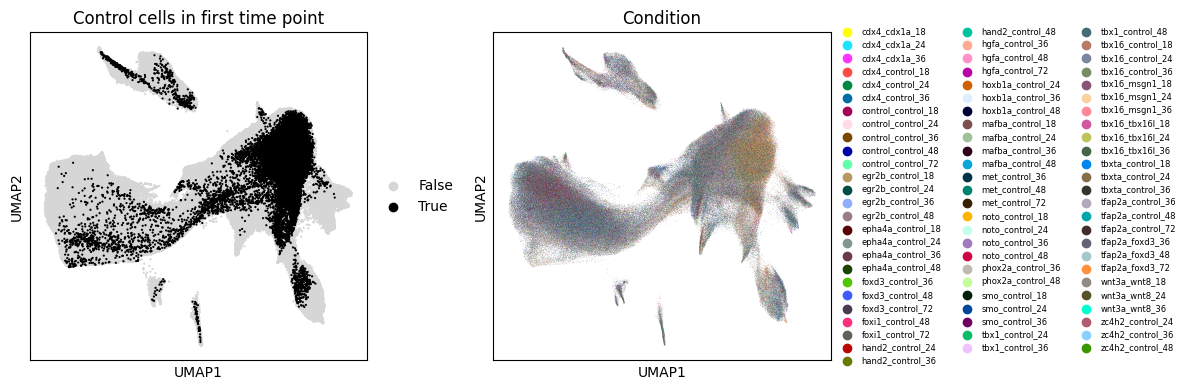

In [7]:
order = list(adata[~adata.obs["first_t_control"].to_numpy()].obs_names) + list(adata[adata.obs["first_t_control"].to_numpy()].obs_names)
adata.obs["first_t_control_str"] = adata.obs["first_t_control"].astype(str)

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Highlight first_t_control
sc.pl.umap(
    adata[order], 
    color="first_t_control_str", 
    size=10, 
    title="Control cells in first time point",
    palette={"True": "#000000", "False": "#D6D6D6"},
    show=False,
    ax=axs[0]
)

# Plot 2: Show condition
sc.pl.umap(
    adata, 
    color="condition", 
    title="Condition",
    show=False,
    ax=axs[1],
    legend_fontsize=6
)

plt.tight_layout()
plt.show()

We also have a closer look at the distribution which we leave out during training.

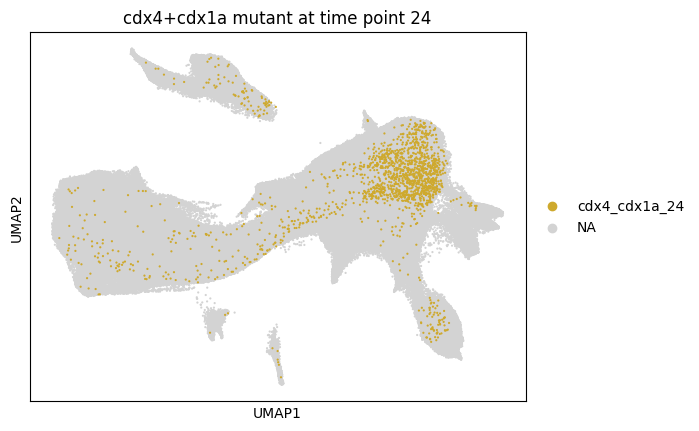

In [8]:
custom_palette = {k: "#D6D6D6" for k in adata.obs["condition"].unique()}
custom_palette.update({"cdx4_cdx1a_24": "#CEA92D"})
order = list(adata[adata.obs["condition"] != "cdx4_cdx1a_24"].obs_names) + \
        list(adata[adata.obs["condition"] == "cdx4_cdx1a_24"].obs_names)

sc.pl.umap(
    adata[order],
    color="condition",
    groups=["cdx4_cdx1a_24"],
    palette=custom_palette,
    title="cdx4+cdx1a mutant at time point 24",
    size=10,
)


We split the data accordingly.

In [ ]:
adata_train = adata[adata.obs["condition"]!="cdx4_cdx1a_24"].copy()
adata_test = adata[(adata.obs["condition"]=="cdx4_cdx1a_24") | (adata.obs["condition"]=="control_control_18")].copy()
adata_train.n_obs, adata_test.n_obs

In [9]:
adata_cond = adata[["cdx4_cdx1a" in x for x in adata.obs["condition"]] | adata.obs["first_t_control"]].copy()
train_ratio = 0.8
n_obs = adata_cond.n_obs

# Generate a shuffled array of indices
shuffled_indices = np.random.permutation(n_obs)

# Calculate the number of observations for the training set
n_train = int(n_obs * train_ratio)

# Split the shuffled indices into training and testing sets
train_indices = shuffled_indices[:n_train]
test_indices = shuffled_indices[n_train:]

# Create the training and testing AnnData objects
adata_train = adata_cond[train_indices, :].copy() # .copy() ensures independent objects
adata_test = adata_cond[test_indices, :].copy()

We use {attr}`obsm['X_aligned'] <anndata.AnnData.obsm>` as cellular representation, i.e. this is the space in which cells are generated. We note that the embedding was obtained from control cells only, with perturbed cells regressed onto it *independently* of other perturbed cells, such that we don't have any data leakage from the test dataset. For details on the embedding, please refer to the [ZSCAPE manuscript](https://www.nature.com/articles/s41586-023-06720-2).

## Setting up the CellFlow model

We are now ready to setup the {class}`~cellflow.model.CellFlow` model.

Therefore, we first choose the flow matching solver. We select the default solver `"otfm"`.

In [18]:
cf = CellFlow(adata_train, solver="otfm")

## Preparing {class}`~cellflow.model.CellFlow`'s data handling with {meth}`~cellflow.model.CellFlow.prepare_data`

- As discussed above, we use {attr}`obsm['X_aligned'] <anndata.AnnData.obsm>` as cellular representation.
- {attr}`obs['first_t_control'] <anndata.AnnData.obs>` indicates whether a cell is a control cell.
- `perturbation_covariates` indicates the external intervention, which is the genetic perturbation. As we also have combinations thereof, we pass the column names `"gene_target_1"` and `"gene_target_2"`. We call this intervention `"genetic_perturbation"`. We use ESM2 embeddings for representing the cytokines, which we have precomputed already for the purpose of this notebook, saved in {attr}`uns['gene_embeddings'] <anndata.AnnData.uns>`. Thus, we pass the information that `"gene_embeddings"` stores embeddings of the {attr}`obs['cytokine'] <anndata.AnnData.obs>` treatments via `perturbation_covariate_reps`.
- The sample covariate describes the cellular context independent of the perturbation. We pass the time point via {attr}`obs['logtime'] <anndata.AnnData.obs>`. 
- The `split_covariates` defines classes within which me map. In contrast to {doc}`200_zebrafish`, we want to learn maps not only from unperturbed to perturbed populations, but from early to later ones as well. In particular, we learn maps from the control distribution at the earliest time point to all other unperturbed and perturbed cellular states. We thus don't have any boundaries for mapping, and set `split_covariates` to `None`.
-  `max_combination_length` is the maximum number of gene knockouts seen during training or inference. We set it to `2`. Note that this value is also automatically inferred from the maximum number of elements seen in `perturbation_covariates`, but can optionally set to be higher for inference.
-  The `null_value` is the value which fills the absence of a perturbation, i.e. the value which fills all positions in {attr}`uns['gene_embeddings']['control'] <anndata.AnnData.uns>`. 

In [19]:
cf.prepare_data(
    sample_rep = "X_aligned",
    control_key = "first_t_control",
    perturbation_covariates = {"genetic_perturbation": ("gene_target_1" , "gene_target_2")},
    perturbation_covariate_reps = {"genetic_perturbation": "gene_embeddings"},
    sample_covariates = ("logtime",),
    split_covariates = None,
    max_combination_length = 2,
    null_value = 0.0,
)

100%|██████████| 4/4 [00:00<00:00, 104.33it/s]


In [20]:
cf.prepare_validation_data(
    adata_train,
    name="train",
    n_conditions_on_log_iteration=None,
    n_conditions_on_train_end=None,
)

cf.prepare_validation_data(
    adata_test,
    name="test",
    n_conditions_on_log_iteration=None,
    n_conditions_on_train_end=None,
)

100%|██████████| 4/4 [00:00<00:00, 217.69it/s]


## Preparing {class}`~cellflow.model.CellFlow`'s model architecture with {meth}`~cellflow.model.CellFlow.prepare_model`

We are now ready to specify the architecture of {class}`~cellflow.model.CellFlow`.

We only consider the most relevant parameters, for a detailed description, please have a look at the documentation of {meth}`~cellflow.model.CellFlow.prepare_model` or {doc}`100_pbmc`.

- We use `condition_mode="deterministic"` to learn point estimates of condition embeddings, and thus have a fully deterministic mapping. We set `regularization=0.0`, thus don't regularize the learnt latent space. 
- `pooling` defines how we aggregate combinations of conditions in a permutation-invariant manner,  which we choose to do learning a class token indicated by `"attention_token"`.
- With `layers_before_pool` we define how to embed the ESM2 embeddings and the log-value of the time. We process them such that have the same scale of dimensionality.
- `condition_embedding_dim` is the dimension of the latent space of the condition encoder.
- `cond_output_dropout` is the dropout applied to the condition embedding, we recommend to set it relatively high, especially if the `condition_embedding_dim` is large.
- `pool_sample_covariates` defines whether the concatenation of the sample covariates should happen before or after pooling, in our case indicating whether it's part of the self-attention or only appended afterwards. 
- `probability_path` defines the reference vector field between pairs of samples which the {class}`~cellflow.networks._velocity_field.ConditionalVelocityField` is regressed against. Here, we use `{"constant_noise": 0.5}`, i.e. we use a relatively small value as we have a highly heterogeneous cell population. In fact, if we augment a cell with noise, we should be careful not to augment it to the extent that it is e.g. in a completely different organ of the zebrafish.
- `match_fn` defines how to sample pairs between the control and the perturbed cells. As we have a strongly heterogeneous population, we choose a higher batch size of 2048. We don't expect large outliers, and are not interested in the trajectory of a single cell, hence we choose `tau_a=tau_b=1.0`.

We start with defining the `layers_before_pool` and `layers_after_pool`. 

In [13]:
layers_before_pool = {
    "genetic_perturbation": {"layer_type": "mlp", "dims": [512, 512], "dropout_rate": 0.0},
    "logtime": {"layer_type": "mlp", "dims": [512, 512], "dropout_rate": 0.0},
}

layers_after_pool = {
    "layer_type": "mlp", "dims": [1024, 1024], "dropout_rate": 0.0,
}

We now also explicitly define the `match_fn`:

In [14]:
match_fn = functools.partial(match_linear, epsilon=0.5, tau_a=1.0, tau_b=1.0)

Now we are ready to prepare the model:

In [21]:
cf.prepare_model(
    condition_mode="deterministic",
    regularization=0.0,
    pooling="attention_token",
    layers_before_pool=layers_before_pool,
    layers_after_pool=layers_after_pool,
    condition_embedding_dim=256,
    cond_output_dropout=0.9,
    hidden_dims=[2048, 2048, 2048],
    decoder_dims=[4096, 4096, 4096],
    probability_path={"constant_noise": 0.5},
    match_fn=match_fn,
    )

## Computing and logging metrics during training 



We compute the energy distance and MMD during training. 

In [16]:
metrics_callback = cellflow.training.Metrics(metrics=["mmd", "e_distance"])
callbacks = [metrics_callback]


## Training CellFlow

Finally, we are ready to train our model. We set the number of iterations relatively high as we have a strongly heterogeneous population. 

In [ ]:
cf.train(
        num_iterations=150_000,
        batch_size=2048,
        callbacks=callbacks,
        valid_freq=30_000,
    )

  0%|          | 265/150000 [00:08<1:08:02, 36.68it/s]

 20%|██        | 30001/150000 [13:43<54:55, 36.42it/s]  


ValueError: Cannot take a larger sample than population when replace is False

We can now investigate some training statistics, stored by the {class}`~cellflow.training.CellFlowTrainer`.

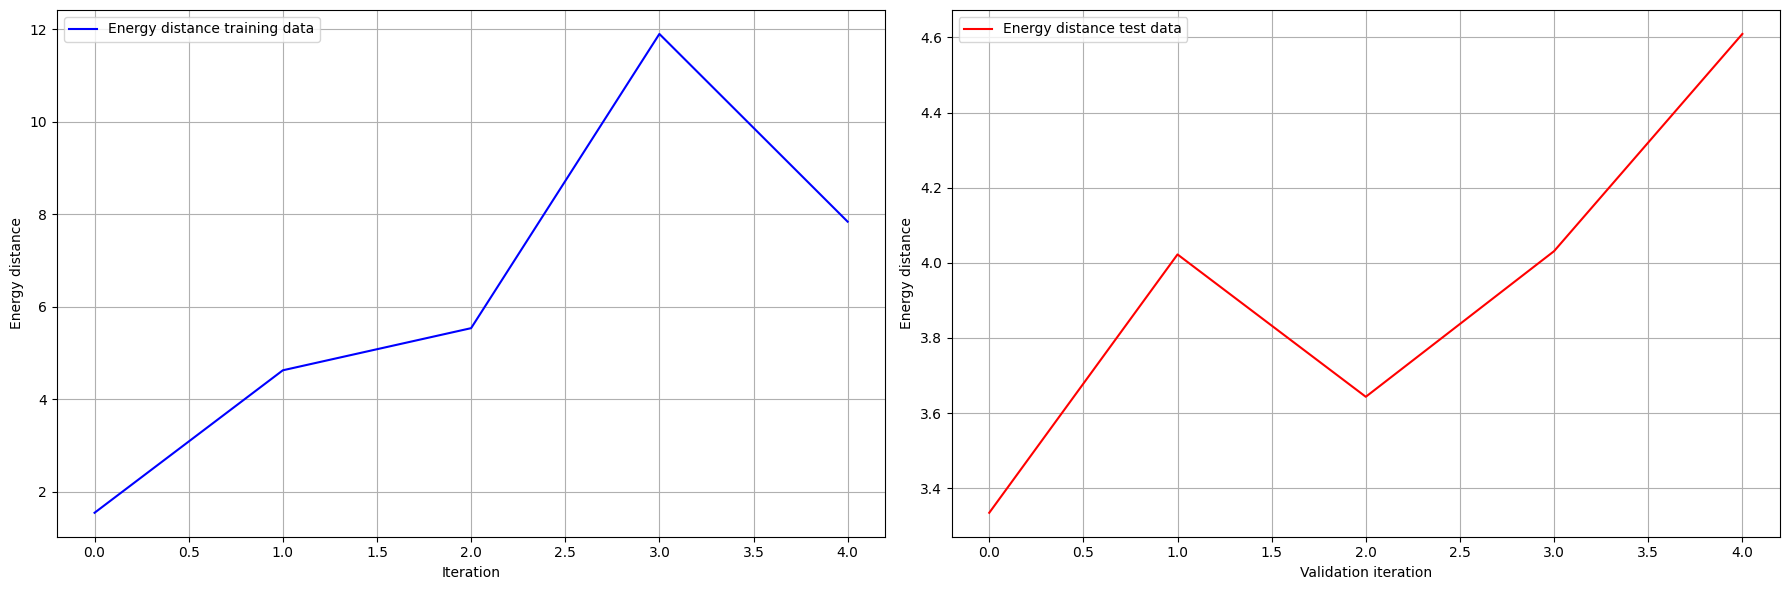

In [24]:
e_distances_train = cf.trainer.training_logs["train_e_distance_mean"]
e_distances_test = cf.trainer.training_logs["test_e_distance_mean"]

iterations_train = np.arange(len(e_distances_train))
iterations_test  = np.arange(len(e_distances_test))

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(iterations_train, e_distances_train, linestyle='-', color='blue', label='Energy distance training data')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Energy distance')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(iterations_test, e_distances_test, linestyle='-', color='red', label='Energy distance test data')
axes[1].set_xlabel('Validation iteration')
axes[1].set_ylabel('Energy distance')
axes[1].legend()
axes[1].grid(True)


plt.tight_layout()
plt.show()


## Investigating the learnt latent space

We can visualize the learnt latent space for any condition using {meth}`~CellFlow.get_condition_embedding`. Note that {meth}`~cellflow.model.CellFlow.get_condition_embedding` returns both the learnt mean embedding and the logvariance. The latter is 0 when `condition_mode="stochastic"`, hence we now only visualize the learnt mean. 
For now, let's use all conditions, but indicate whether they're seen during training or not:

In [25]:
covariate_data_train = adata_train[~adata_train.obs["is_control"].to_numpy()].obs.drop_duplicates(subset=["condition"])
covariate_data_test = adata_test[~adata_test.obs["is_control"].to_numpy()].obs.drop_duplicates(subset=["condition"])

df_embedding_train = cf.get_condition_embedding(covariate_data=covariate_data_train, condition_id_key="condition", rep_dict=adata_train.uns)[0]
df_embedding_test = cf.get_condition_embedding(covariate_data=covariate_data_test, condition_id_key="condition", rep_dict=adata_train.uns)[0]

df_embedding_train["seen_during_training"] = True
df_embedding_test["seen_during_training"] = False
df_condition_embedding = pd.concat((df_embedding_train, df_embedding_test))

100%|██████████| 3/3 [00:00<00:00, 687.22it/s]


In [26]:
df_embedding_test

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,seen_during_training
condition,,,,,,,,,,,,,,,,,,,,,
cdx4_cdx1a_36,0.161117,-0.177073,0.182573,0.194787,0.157334,-0.216256,0.175895,0.166951,0.174958,0.207833,...,-0.183469,-0.204723,0.199061,-0.173479,-0.198992,-0.208657,-0.218691,-0.187743,0.170700,False
cdx4_cdx1a_18,-0.106569,0.131252,-0.117416,-0.123377,-0.107935,0.137958,-0.121290,-0.125709,-0.130284,-0.116464,...,0.108046,0.129382,-0.113715,0.117382,0.123058,0.137083,0.113851,0.128312,-0.124175,False
cdx4_cdx1a_24,0.004271,0.003605,0.006801,0.008349,0.001904,-0.008699,0.001755,-0.004525,-0.003893,0.017804,...,-0.012655,-0.008970,0.015770,-0.003049,-0.010293,-0.006076,-0.023825,-0.002549,-0.002091,False


We can now visualize the embedding, which is 256-dimensional, by calling {meth}`~cellflow.plotting.plot_condition_embedding`. We first visualize it according to whether it was seen during training or not. We choose a kernel PCA representation, but we recommend trying other dimensionaly reduction methods as well. We can see that the unseen conditions integrate well.

In [27]:
fig = plot_condition_embedding(df_condition_embedding, embedding="PCA", hue="seen_during_training", circle_size=50)

ValueError: n_components=30 must be between 1 and min(n_samples, n_features)=6 with svd_solver='arpack'

We can see that conditions from the same perturbation cluster along the second principal component of the embedding ...

In [28]:
df_condition_embedding["condition"] = df_condition_embedding.index
df_condition_embedding["genetic_perturbation"] = df_condition_embedding.apply(lambda x: "_".join(x["condition"].split("_")[:2]), axis=1)
fig = plot_condition_embedding(df_condition_embedding, embedding="PCA", hue="genetic_perturbation", circle_size=50)

ValueError: n_components=30 must be between 1 and min(n_samples, n_features)=6 with svd_solver='arpack'

... while the first principal component captures the variance across time points.

In [ ]:
df_condition_embedding["time_point"] = df_condition_embedding.apply(lambda x: x["condition"].split("_")[-1], axis=1)
fig = plot_condition_embedding(df_condition_embedding, embedding="PCA", hue="time_point", circle_size=50, legend=False)


## Predicting with CellFlow

Here, we want to predict the continuous development of the cdx4-cdx1a perturbed zebrafish. Hence, we need to create `covariate_data` which contains conditions corresponding to densely sampled time points.

In [ ]:
def duplicate_and_interpolate(df, column, start, end, steps):
    result = pd.DataFrame()
    
    for _, row in df.iterrows():
        new_rows = pd.DataFrame([row] * steps)  # Duplicate the row
        new_rows[column] = np.log(np.linspace(start, end, steps)) # Log-transform the time point
        result = pd.concat([result, new_rows], ignore_index=True)
    
    return result
    
covariate_data_interpolated = duplicate_and_interpolate(covariate_data_test, 'logtime', 18, 48, 20)
covariate_data_interpolated.loc[:, "condition"] = covariate_data_interpolated.apply(lambda x: "_".join([x.gene_target, str(int(np.round(np.exp(x.logtime))))]), axis=1)
covariate_data_interpolated.head()

In [38]:
covariate_data_interpolated["condition"].unique()

array(['cdx4_cdx1a_18', 'cdx4_cdx1a_20', 'cdx4_cdx1a_21', 'cdx4_cdx1a_23',
       'cdx4_cdx1a_24', 'cdx4_cdx1a_26', 'cdx4_cdx1a_27', 'cdx4_cdx1a_29',
       'cdx4_cdx1a_31', 'cdx4_cdx1a_32', 'cdx4_cdx1a_34', 'cdx4_cdx1a_35',
       'cdx4_cdx1a_37', 'cdx4_cdx1a_39', 'cdx4_cdx1a_40', 'cdx4_cdx1a_42',
       'cdx4_cdx1a_43', 'cdx4_cdx1a_45', 'cdx4_cdx1a_46', 'cdx4_cdx1a_48'],
      dtype=object)

We also need to provide control cells:

In [31]:
adata_ctrl = adata[(adata.obs["gene_target"]=="control_control") & (adata.obs["timepoint"]==18)]
preds = cf.predict(adata=adata_ctrl, sample_rep="X_aligned", covariate_data=covariate_data_interpolated)

100%|██████████| 20/20 [00:00<00:00, 759.21it/s]


We now build an {class}`adata <anndata.AnnData>` object to store the predictions in {attr}`adata.obsm <anndata.AnnData.obsm>`:

In [ ]:
adata_preds = []
for cond, array in preds.items():
    
    obs_data = pd.DataFrame({
        'condition': [cond] * array.shape[0]
    })
    adata_pred = ad.AnnData(X=np.empty((len(array),adata_train.n_vars)), obs=obs_data)
    adata_pred.obsm["X_aligned"] = np.squeeze(array)
    adata_preds.append(adata_pred)

adata_preds = ad.concat(adata_preds)
adata_preds.var_names = adata_train.var_names

In [40]:
adata_preds.obs.head()

,condition,cell_type_broad_transfer,cell_type_broad_transfer_score
0,"(cdx4, cdx1a, 2.8903717578961645)",neural progenitor (hindbrain R7/8),1.0
1,"(cdx4, cdx1a, 2.8903717578961645)",neural progenitor (MHB),1.0
2,"(cdx4, cdx1a, 2.8903717578961645)",neural progenitor (MHB),1.0
3,"(cdx4, cdx1a, 2.8903717578961645)",neural progenitor (hindbrain),1.0
4,"(cdx4, cdx1a, 2.8903717578961645)",neural progenitor (hindbrain R7/8),1.0


We now transfer labels using the 1NN classifier based on the training data. Therefore, we first have to compute a nearest neighbor graph, and then transfer the labels subsequently

In [33]:
compute_wknn(ref_adata=adata, query_adata=adata_preds, n_neighbors=1, ref_rep_key="X_aligned", query_rep_key="X_aligned")
transfer_labels(query_adata=adata_preds, ref_adata=adata, label_key="cell_type_broad")

Now, we can compute the cell type fractions over time:

In [36]:
df_pert_timepoint = adata_preds.obs.groupby(["condition"])["cell_type_broad_transfer"].value_counts(normalize=True).to_frame(name="fraction").reset_index()
df_pert_timepoint["timepoint"] = df_pert_timepoint.apply(lambda x: x["condition"][-1], axis=1)
df_pert_timepoint["condition"].unique()

array([('cdx4', 'cdx1a', 2.8903717578961645),
       ('cdx4', 'cdx1a', 2.974454875106706),
       ('cdx4', 'cdx1a', 3.052013109452581),
       ('cdx4', 'cdx1a', 3.12398660907767),
       ('cdx4', 'cdx1a', 3.1911259119152984),
       ('cdx4', 'cdx1a', 3.2540397373258676),
       ('cdx4', 'cdx1a', 3.3132286087161984),
       ('cdx4', 'cdx1a', 3.3691090671106547),
       ('cdx4', 'cdx1a', 3.4220314685649975),
       ('cdx4', 'cdx1a', 3.4722933033458854),
       ('cdx4', 'cdx1a', 3.520149324523521),
       ('cdx4', 'cdx1a', 3.565819361356709),
       ('cdx4', 'cdx1a', 3.6094944248593706),
       ('cdx4', 'cdx1a', 3.651341534794871),
       ('cdx4', 'cdx1a', 3.691507576520206),
       ('cdx4', 'cdx1a', 3.7301224126479857),
       ('cdx4', 'cdx1a', 3.7673014158897393),
       ('cdx4', 'cdx1a', 3.803147547662875),
       ('cdx4', 'cdx1a', 3.8377530768403507),
       ('cdx4', 'cdx1a', 3.871201010907891)], dtype=object)

In [35]:
df_pert_timepoint

,condition,cell_type_broad_transfer,fraction
0,"(cdx4, cdx1a, 2.8903717578961645)",neural progenitor (hindbrain),0.396378
1,"(cdx4, cdx1a, 2.8903717578961645)",neural progenitor (telencephalon/diencephalon),0.166331
2,"(cdx4, cdx1a, 2.8903717578961645)",neural progenitor (MHB),0.138296
3,"(cdx4, cdx1a, 2.8903717578961645)",neural progenitor (hindbrain R7/8),0.108719
4,"(cdx4, cdx1a, 2.8903717578961645)",neural progenitor (diencephalon/telencephalon),0.041583
...,...,...,...
495,"(cdx4, cdx1a, 3.871201010907891)",glia,0.002280
496,"(cdx4, cdx1a, 3.871201010907891)",KA neuron,0.002146
497,"(cdx4, cdx1a, 3.871201010907891)",dorsal spinal cord neuron,0.001543
498,"(cdx4, cdx1a, 3.871201010907891)",neuron (dopaminergic),0.001140


We can now visualize the perturbed development of cdx4+cdx1a mutants over time:

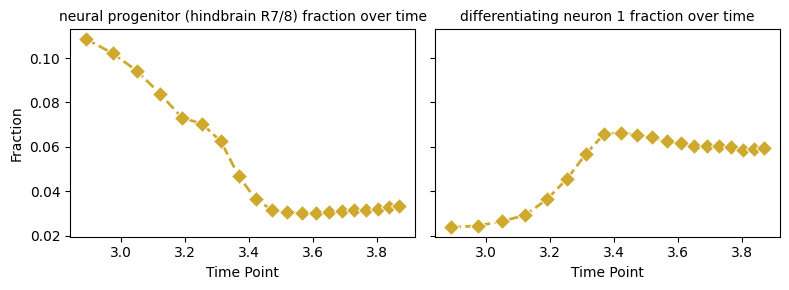

In [37]:
cell_types = [
    ("neural progenitor (hindbrain R7/8)", "#CEA92D"),
    ("differentiating neuron 1", "#CEA92D")
]

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

for ax, (cell_type, color) in zip(axes, cell_types):
    data = df_pert_timepoint[df_pert_timepoint["cell_type_broad_transfer"] == cell_type]
    sns.lineplot(
        data=data,
        x="timepoint",
        y="fraction",
        marker="D",
        linestyle="--",
        linewidth=2,
        markersize=8,
        alpha=1.0,
        color=color,
        ax=ax
    )
    ax.set_title(f"{cell_type} fraction over time", fontsize=10)
    ax.set_xlabel("Time Point", fontsize=10)
    ax.set_ylabel("Fraction" if ax == axes[0] else "", fontsize=10)
    ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()


In [ ]:
data

In [ ]:
df_condition_embedding